In [1]:
import pandas as pd
# import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
# from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import gc

In [2]:
train = pd.read_csv('training_dataset/hourly_dataset.csv')
train['time'] = pd.to_datetime(train['time'])

In [3]:
train1 = train[(train['time'] >= '2022-01-01 01:00:00') &
               (train['time'] < '2022-05-01 01:00:00')].reset_index(drop=True)
# test1 = train[train['train or test']=='test1'].reset_index(drop=True)

train2 = train[(train['time'] >= '2022-05-08 01:00:00') &
               (train['time'] < '2022-06-01 01:00:00')].reset_index(drop=True)
# test2 = train[train['train or test']=='test2'].reset_index(drop=True)

train3 = train[(train['time'] >= '2022-06-08 01:00:00') &
               (train['time'] < '2022-07-21 01:00:00')].reset_index(drop=True)
# test3 = train[train['train or test']=='test3'].reset_index(drop=True)

train4 = train[(train['time'] >= '2022-07-28 01:00:00') &
               (train['time'] < '2022-08-21 01:00:00')].reset_index(drop=True)
# test4 = train[train['train or test']=='test4'].reset_index(drop=True)


In [4]:
## 将小于零的值替换为空值
for df in tqdm([train1,train2,train3,train4]):
    for i in range(1,21):
        df.loc[df[f'flow_{i}']<0,f'flow_{i}'] = np.nan
        
        
## 将异常值替换为空值
for df in tqdm([train1,train2,train3,train4]):
    for i in range(1,21):
        df[f'flow_{i}_shift'] = df[f'flow_{i}'].shift(-1)
        for index,row in df.iterrows():
            if index != df.shape[0]-1:
                if pd.isna(row[f'flow_{i}_shift']) and pd.notna(row[f'flow_{i}']):
                    df.loc[index,f'flow_{i}'] = np.nan
        del df[f'flow_{i}_shift'];gc.collect

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
for i in range(1, 5):
    locals()[f'train{i}'] = locals()[f'train{i}'].set_index('time')

for df in [train1, train2, train3, train4]:
    for date in tqdm(df.index):
        for col in range(20):
            period1 = pd.Timedelta(hours=24)
            if pd.isna(df.loc[date][col]):  # 判断是否为空值
                if date - period1 in df.index:  # 如果该索引存在 （考虑到一下flow一开始就存在空值）
                    period2 = date - period1
                    while pd.isna(df.loc[period2][col]):
                        period2 = period2 - period1
                    df.loc[date,
                           f'flow_{col+1}'] = df.loc[period2, f'flow_{col+1}']

                else:  # 对于flow一开始就存在缺失值的，用后一天的值进行填充
                    period2 = date + pd.Timedelta(hours=24)
                    while pd.isna(df.loc[period2][col]):
                        period2 = period2 + period1
                    df.loc[date,
                           f'flow_{col+1}'] = df.loc[period2, f'flow_{col+1}']


for i in range(1, 5):
    locals()[f'train{i}'] = locals()[f'train{i}'].reset_index()


  0%|          | 0/2880 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]

  0%|          | 0/1032 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]

In [15]:
sub = pd.read_csv('sample_submission.csv')

# sub1 = (train1.iloc[-24*7*1:,1:-1].values + train1.iloc[-24*7*2:-24*7*1,1:-1].values + \
#         train1.iloc[-24*7*3:-24*7*2,1:-1].values + train1.iloc[-24*7*4:-24*7*3,1:-1].values)/4
# sub.loc[(sub['time']>='2022-05-01 01:00:00')&(sub['time']<'2022-05-08 01:00:00'),1:] = sub1


# sub1 = (train2.iloc[-24*7*1:,1:-1].values + train2.iloc[-24*7*2:-24*7*1,1:-1].values + \
#         train2.iloc[-24*7*3:-24*7*2,1:-1].values)/3
# sub.loc[(sub['time']>='2022-06-01 01:00:00')&(sub['time']<'2022-06-08 01:00:00'),1:] = sub1


# sub1 = (train3.iloc[-24*7*1:,1:-1].values + train3.iloc[-24*7*2:-24*7*1,1:-1].values + \
#         train3.iloc[-24*7*3:-24*7*2,1:-1].values + train3.iloc[-24*7*4:-24*7*3,1:-1].values)/4
# sub.loc[(sub['time']>='2022-07-21 01:00:00')&(sub['time']<'2022-07-28 01:00:00'),1:] = sub1


# sub1 = (train4.iloc[-24*7*1:,1:-1].values + train4.iloc[-24*7*2:-24*7*1,1:-1].values + \
#         train4.iloc[-24*7*3:-24*7*2,1:-1].values)/3
# sub.loc[(sub['time']>='2022-08-21 01:00:00')&(sub['time']<'2022-08-28 01:00:00'),1:] = sub1
sub1 = ((train1.iloc[-24*7*1:-24*6,1:-1].values + train1.iloc[-24*7*2:-24*7*1-24*6,1:-1].values + \
         train1.iloc[-24*7*3:-24*7*2-24*6,1:-1].values + train1.iloc[-24*7*4:-24*7*3-24*6,1:-1].values)/4)\
             * 0.2 + train1.iloc[-24*1:,1:-1].values * 0.8
sub.loc[(sub['time']>='2022-05-01 01:00:00')&(sub['time']<'2022-05-02 01:00:00'),1:] = sub1
for i in range(2, 8):
    if i == 7 :
        sub.iloc[24*(i-1)*1:24*(i),1:] = ((train1.iloc[-24*1:,1:-1].values + train1.iloc[-24*7*1-24*1:-24*7*1,1:-1].values +\
            + train1.iloc[-24*7*2-24*1:-24*7*2,1:-1].values + train1.iloc[-24*7*3-24*1:-24*7*3,1:-1].values)/4)\
                 * 0.4 + sub.iloc[24*(i-2)*1:24*(i-1),1:].values * 0.6
    else:
        sub1 = ((train1.iloc[-24*(8-i)*1:-24*(7-i),1:-1].values + train1.iloc[-24*7*1-24*(8-i)*1:-24*7*1-24*(7-i),1:-1].values +\
            train1.iloc[-24*7*2-24*(8-i)*1:-24*7*2-24*(7-i),1:-1].values + train1.iloc[-24*7*3-24*(8-i)*1:-24*7*3-24*(7-i),1:-1].values)/4)\
                 * 0.4 + sub.iloc[24*(i-2)*1:24*(i-1),1:].values * 0.6
        sub.iloc[24*(i-1)*1:24*(i),1:] = sub1

sub2 = ((train2.iloc[-24*7*1:-24*6,1:-1].values + train2.iloc[-24*7*2:-24*7*1-24*6,1:-1].values + \
         train2.iloc[-24*7*3:-24*7*2-24*6,1:-1].values)/3)\
             * 0.2 + train2.iloc[-24*1:,1:-1].values * 0.8
sub.loc[(sub['time']>='2022-06-01 01:00:00')&(sub['time']<'2022-06-02 01:00:00'),1:] = sub2
for i in range(2, 8):
    if i == 7 :
        sub.iloc[24*7*1 + 24*(i-1)*1:24*7 + 24*(i),1:] = ((train2.iloc[-24*1:,1:-1].values + train2.iloc[-24*7*1-24*1:-24*7*1,1:-1].values +\
            + train2.iloc[-24*7*2-24*1:-24*7*2,1:-1].values)/3)\
                 * 0.4 + sub.iloc[24*7*1 + 24*(i-2)*1:24*7*1 + 24*(i-1),1:].values * 0.6
    else:
        sub.iloc[24*7*1 + 24*(i-1)*1:24*7*1 + 24*(i),1:] = ((train2.iloc[-24*(8-i)*1:-24*(7-i),1:-1].values + train2.iloc[-24*7*1-24*(8-i)*1:-24*7*1-24*(7-i),1:-1].values +\
            train2.iloc[-24*7*2-24*(8-i)*1:-24*7*2-24*(7-i),1:-1].values)/3)\
                 *0.4 + sub.iloc[24*7*1 + 24*(i-2)*1:24*7*1 + 24*(i-1),1:].values * 0.6
        
sub3 = ((train3.iloc[-24*7*1:-24*6,1:-1].values + train3.iloc[-24*7*2:-24*7*1-24*6,1:-1].values + \
         train3.iloc[-24*7*3:-24*7*2-24*6,1:-1].values + train3.iloc[-24*7*4:-24*7*3-24*6,1:-1].values)/4)\
             * 0.2 + train3.iloc[-24*1:,1:-1].values * 0.8
sub.loc[(sub['time']>='2022-07-21 01:00:00')&(sub['time']<'2022-07-22 01:00:00'),1:] = sub3
for i in range(2, 8):
    if i == 7 :
        sub.iloc[24*7*2 + 24*(i-1)*1:24*7*2 + 24*(i),1:] = ((train3.iloc[-24*1:,1:-1].values + train3.iloc[-24*7*1-24*1:-24*7*1,1:-1].values +\
            + train3.iloc[-24*7*2-24*1:-24*7*2,1:-1].values + train3.iloc[-24*7*3-24*1:-24*7*3,1:-1].values)/4)\
                 * 0.4 + sub.iloc[24*7*2 + 24*(i-2)*1:24*7*2 + 24*(i-1),1:].values * 0.6
    else:
        sub.iloc[24*7*2 + 24*(i-1)*1:24*7*2 + 24*(i),1:] = ((train3.iloc[-24*(8-i)*1:-24*(7-i),1:-1].values + train3.iloc[-24*7*1-24*(8-i)*1:-24*7*1-24*(7-i),1:-1].values +\
            train3.iloc[-24*7*2-24*(8-i)*1:-24*7*2-24*(7-i),1:-1].values + train3.iloc[-24*7*3-24*(8-i)*1:-24*7*3-24*(7-i),1:-1].values)/4)\
                 * 0.4 + sub.iloc[24*7*2 + 24*(i-2)*1:24*7*2 + 24*(i-1),1:].values * 0.6

sub4 = ((train4.iloc[-24*7*1:-24*6,1:-1].values + train4.iloc[-24*7*2:-24*7*1-24*6,1:-1].values + \
         train4.iloc[-24*7*3:-24*7*2-24*6,1:-1].values)/3)\
             * 0.2 + train4.iloc[-24*1:,1:-1].values * 0.8
sub.loc[(sub['time']>='2022-08-21 01:00:00')&(sub['time']<'2022-08-22 01:00:00'),1:] = sub4
for i in range(2, 8):
    if i == 7 :
        sub.iloc[24*7*3 + 24*(i-1)*1:24*7*3 + 24*(i),1:] = ((train4.iloc[-24*1:,1:-1].values + train4.iloc[-24*7*1-24*1:-24*7*1,1:-1].values +\
            + train4.iloc[-24*7*2-24*1:-24*7*2,1:-1].values)/3) \
                * 0.4 + sub.iloc[24*7*3 + 24*(i-2)*1:24*7*3 + 24*(i-1),1:].values * 0.6
    else:
        sub.iloc[24*7*3 + 24*(i-1)*1:24*7*3 + 24*(i),1:] = ((train4.iloc[-24*(8-i)*1:-24*(7-i),1:-1].values + train4.iloc[-24*7*1-24*(8-i)*1:-24*7*1-24*(7-i),1:-1].values +\
            train4.iloc[-24*7*2-24*(8-i)*1:-24*7*2-24*(7-i),1:-1].values)/3)\
                 * 0.4 + sub.iloc[24*7*3 + 24*(i-2)*1:24*7*3 + 24*(i-1),1:].values * 0.6
        

C:\Users\Peterhuangzi\AppData\Local\Temp\ipykernel_21592\1156483400.py:24: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  sub.loc[(sub['time']>='2022-05-01 01:00:00')&(sub['time']<'2022-05-02 01:00:00'),1:] = sub1
C:\Users\Peterhuangzi\AppData\Local\Temp\ipykernel_21592\1156483400.py:39: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  sub.loc[(sub['time']>='2022-06-01 01:00:00')&(sub['time']<'2022-06-02 01:00:00'),1:] = sub2
C:\Users\Peterhuangzi\AppData\Local\Temp\ipykernel_21592\1156483400.py:53: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  sub.loc[(sub['time']>='2022-07-21 01:00:00')&(sub['time']<'2022-07-22 01

In [2]:
import tensorflow as tf


def cal_msle(test, pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
# mse = tf.keras.losses.MeanSquaredError()
# mse(test, pred).numpy()
    return msle(test, pred).numpy()


# for j in range(0, 4):
#     loss = 0

#     for i in range(1, 21):
#         test = pd.read_csv('test.csv').iloc[24*7*j:24*7*(j+1), i].values
#         pred = pd.read_csv('weight.csv').iloc[24*7*j:24*7*(j+1), i].values
#         loss += cal_msle(test, pred)
#     print(loss)



1.1490672648038636
0.41452540429923
0.31843629442921534
0.18447170978870334


In [5]:
test = pd.read_csv('sarimax.csv')
weight = pd.read_csv('weight.csv')
test.iloc[:24*7*2,:] = weight.iloc[:24*7*2,:]
test.to_csv("test.csv",index = False)

In [8]:
sub.to_csv('test.csv',index = False)

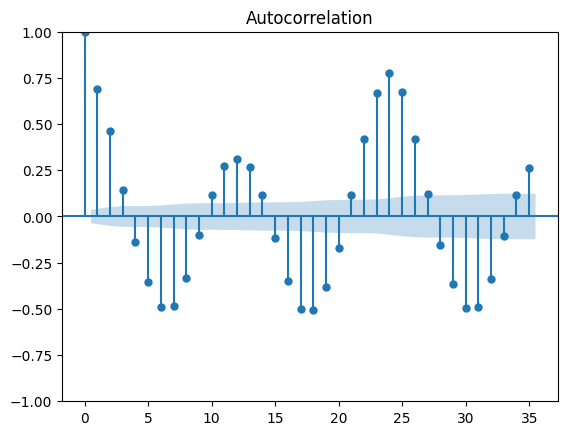

Original series adf result: (-6.397116401526067, 2.0378705106539392e-08, 28, 2851, {'1%': -3.43264575500919, '5%': -2.862554307267278, '10%': -2.567309945727228}, 21851.465598785333)


In [6]:
#ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
'''
ARIMA是'Auto Regressive Integrated Moving Average'的简称。
ARIMA是一种基于时间序列历史值和历史值上的预测误差来对当前做预测的模型。
ARIMA整合了自回归项AR和滑动平均项MA。
ARIMA可以建模任何存在一定规律的非季节性时间序列。
如果时间序列具有季节性,则需要使用SARIMA(Seasonal ARIMA)建模,
ARIMA模型有三个超参数:p,d,q

p
 AR(自回归)项的阶数。需要事先设定好,表示y的当前值和前p个历史值有关。 
d
 使序列平稳的最小差分阶数,一般是1阶。非平稳序列可以通过差分来得到平稳序列,
 但是过度的差分,会导致时间序列失去自相关性,从而失去使用AR项的条件。
q
 MA(滑动平均)项的阶数。需要事先设定好,表示y的当前值和前q个历史值AR预测误差有关。
 实际是用历史值上的AR项预测误差来建立一个类似归回的模型。
'''
#orginal series
# plt.plot(train1['flow_1'].values); 
# plt.set_title('Original Series')
plot_acf(train1['flow_1'].values)
plt.show()
print("Original series adf result: {}".format(ADF(train1['flow_1'])))

In [30]:
for index, row in train1.iloc[:,1:-1].items():
    if ADF(train1[index])[1] > 0.05:
        print(index)

In [16]:
#choose orginal series
pmax = int(len(train1)/100)
qmax = int(len(train1)/100)
bic_matrix = []
for p in tqdm(range(10)):
    tmp = []
    for q in range(10):
        try:
            value = ARIMA(train1.iloc[:-24*7, 1], order=(p, 0, q)).fit().bic
            tmp.append(value)
            # print(value)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
print('*'*20)    

bic_matrix = pd.DataFrame(bic_matrix)
print(bic_matrix)

p, q = bic_matrix.stack().astype('float64').idxmin()
print('BIC最小的p值和q值为:%s. %s' % (p, q))

  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\Peterhuangzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Peterhuangzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Peterhuangzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Peterhuangzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

********************
              0             1             2             3             4  \
0  24271.323544  23187.890649  22615.697797  22409.432258  22375.767051   
1  22544.624426  22551.250104  22379.740124  22365.745724  22357.758284   
2  22550.063668  22541.972356  21865.176277  21670.411377  21532.687859   
3  22258.323318  22008.220893  21544.826262  21509.398093  21446.482185   
4  22093.397566  21998.056530  21458.324495  21578.723577  21493.554128   
5  22019.837277  21991.791350  21458.383706  21516.953876  21588.959664   
6  21968.604087  21975.169468  21567.302556  21549.793909  21517.053884   
7  21972.734970  21975.293065  21784.368970  21845.067937  21456.623018   
8  21941.558201  21916.185084  21460.296807  21785.228919  21835.291081   
9  21882.837272  21889.101728  21873.184914  21444.975756  21518.667641   

              5             6             7             8             9  
0  22327.593868  22283.364488  22288.943533  22152.222523  22016.820648  
1  22

In [28]:
model = ARIMA(train1.iloc[:-24*7, 1], order=(p, 0, q)).fit()
pred = model.forecast(24*7)
test = train1.iloc[-24*7:,1].values
msle = cal_msle(test, pred)
msle

c:\Users\Peterhuangzi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.13355376338497874

<Figure size 640x480 with 0 Axes>

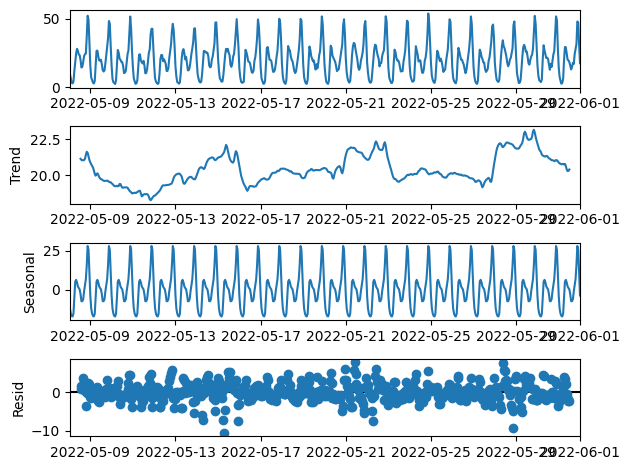

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose
train2["time"] = pd.to_datetime(train2["time"])
train2 = train2.set_index("time")
result = seasonal_decompose(train2.iloc[:, 1:2], model='additive')
fig = plt.figure()
fig = result.plot()
plt.show()

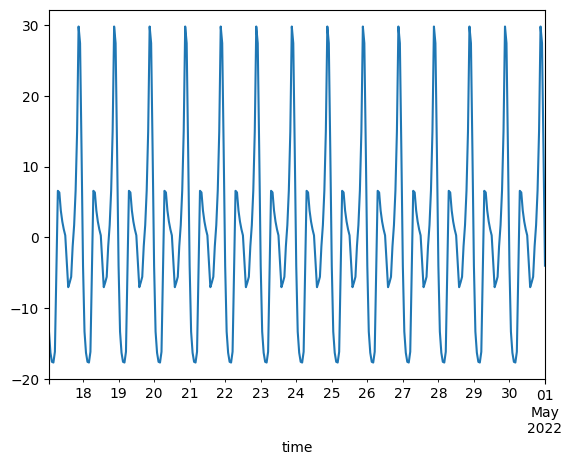

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
# train1["time"] = pd.to_datetime(train1["time"])
# train1 = train1.set_index("time")
result = seasonal_decompose(train1.iloc[-24*14:, 1:2], model='additive')
fig = plt.figure()
fig = result.seasonal.plot()
plt.show()

In [6]:
from pmdarima.arima import auto_arima
arima_model = auto_arima(train1['flow_1'], start_p=0, d = 0, start_q=0, max_p=10, max_d=0, max_q=10,
                        start_P=1, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=24, seasonal=True, error_action='warn', trace=True, suppress_warnings=True,
                        stepwise=True, random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,0)[24] intercept   : AIC=22428.659, Time=11.85 sec
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=23258.728, Time=0.43 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=22421.040, Time=18.15 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=inf, Time=19.49 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=23256.748, Time=0.27 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=23253.485, Time=1.21 sec
 ARIMA(1,0,0)(2,1,0)[24] intercept   : AIC=22051.996, Time=130.14 sec
 ARIMA(1,0,0)(3,1,0)[24] intercept   : AIC=21919.982, Time=279.36 sec
 ARIMA(1,0,0)(4,1,0)[24] intercept   : AIC=21852.824, Time=336.39 sec
 ARIMA(1,0,0)(5,1,0)[24] intercept   : AIC=21778.316, Time=588.30 sec
 ARIMA(1,0,0)(5,1,1)[24] intercept   : AIC=inf, Time=709.47 sec
 ARIMA(1,0,0)(4,1,1)[24] intercept   : AIC=inf, Time=533.87 sec
 ARIMA(0,0,0)(5,1,0)[24] intercept   : AIC=21790.753, Time=521.98 sec
 ARIMA(2,0,0)(5,1,0)[24] intercept   : AIC=21693.600, Time=651.76 sec


MemoryError: Unable to allocate 2.68 MiB for an array with shape (122, 2881) and data type float64